In [1]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

import xgboost as xgb
import matplotlib.pyplot as plt

from utils import preprocess


In [2]:
def delete_unrelated_feilds(df):
    fields = set(df.keys())
    for k in fields:
        if 'Unnamed' in k:
            df.drop(k, axis=1, inplace=True)
    return df

df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')

df = delete_unrelated_feilds(df)
df_test = delete_unrelated_feilds(df_test)

df.to_csv('./data/train_feature.csv')
df_test.to_csv('./data/test_feature.csv')

In [3]:
df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [ ]:
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)
df = delete_unrelated_feilds(df)
df_test = delete_unrelated_feilds(df_test)


In [10]:
# for t in [df, df_test]:
#     for a in class2author:
# #         pass
#         t.drop('{}_fasttext_cbow_wide_logi'.format(a), axis=1, inplace=True)
#     #     df_test.drop('{}_fasttext_cbow_wide_logi'.format(a), axis=1, inplace=True)    
#         t.drop('{}_fasttext_bigram_reverse'.format(a), axis=1, inplace=True)
#         t.drop('{}_lstm'.format(a), axis=1, inplace=True)
#         t.drop('{}_word2vec_google_logi'.format(a), axis=1, inplace=True)    

# #     df_test.drop('{}_fasttext_bigram_reverse'.format(a), axis=1, inplace=True)        
# #     df.drop('{}_fasttext_skip_low_dim_logi'.format(a), axis=1, inplace=True)
# #     df_test.drop('{}_fasttext_skip_low_dim_logi'.format(a), axis=1, inplace=True)        
# #     df.drop('{}_char_wb_count_NB'.format(a), axis=1, inplace=True)
# #     df_test.drop('{}_char_wb_count_NB'.format(a), axis=1, inplace=True)
# # df.drop('num_words'.format(a), axis=1, inplace=True)
#     # df_test.drop('num_words'.format(a), axis=1, inplace=True)                
# #     t.drop('rate_uniq_chars', axis=1, inplace=True)
# #     t.drop('HPL_char_wb_count_NB', axis=1, inplace=True)
# #     t.drop('num_words', axis=1, inplace=True)


In [27]:
num_split = 5
np.random.seed(1234)
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.095 #01
param['max_depth'] = 2
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = 'mlogloss'
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3 # 0.3
param['seed'] = 7
num_rounds = 6000


kf = KFold(n_splits=num_split, shuffle=True, random_state=2017)
results = np.zeros((len(df_test), 3))

losses = []
ite = 5
for train_ids, val_ids in kf.split(df):
    x_train, x_val = df.loc[train_ids], df.loc[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)
    xgtest = xgb.DMatrix(x_val, label=y_val)
    
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=100)

    l = log_loss(y_true=y_val, y_pred=model.predict(xgtest, ntree_limit=model.best_ntree_limit))
    losses.append(l)
    
    xgtest2 = xgb.DMatrix(df_test)
    results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
losses    
    

[0]	train-mlogloss:1.00134	test-mlogloss:1.00077
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.257964	test-mlogloss:0.269772
[200]	train-mlogloss:0.236138	test-mlogloss:0.263238
[300]	train-mlogloss:0.22165	test-mlogloss:0.261616
[400]	train-mlogloss:0.209282	test-mlogloss:0.261229
[500]	train-mlogloss:0.198963	test-mlogloss:0.261555
Stopping. Best iteration:
[408]	train-mlogloss:0.208372	test-mlogloss:0.261109

[0]	train-mlogloss:1.00124	test-mlogloss:1.00233
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.256383	test-mlogloss:0.278318
[200]	train-mlogloss:0.233985	test-mlogloss:0.270298
[300]	train-mlogloss:0.219638	test-mlogloss:0.268864
[400]	train-mlogloss:0.207898	test-mlogloss:0.268807
Stopping. Best iteration:
[319]	train-mlog

[0.26110885369058195,
 0.26870388442692422,
 0.27684031871204318,
 0.25272937572359239,
 0.25491136134005221]

In [28]:
losses = np.array(losses)
losses, np.mean(losses)

(array([ 0.26110885,  0.26870388,  0.27684032,  0.25272938,  0.25491136]),
 0.26285875877863879)

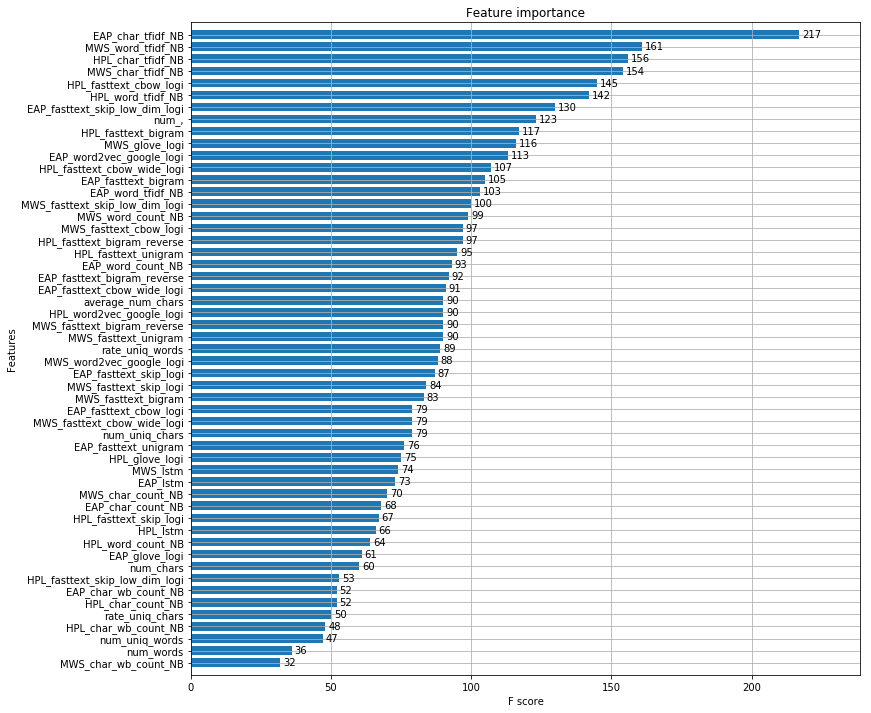

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=100, height=0.7, ax=ax)
plt.show()

In [30]:
submission_df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    submission_df[a] = results[:, i]/num_split

with open('./results/results.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in submission_df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')

In [25]:
df

,EAP_fasttext_skip_logi,HPL_fasttext_skip_logi,MWS_fasttext_skip_logi,EAP_fasttext_skip_low_dim_logi,HPL_fasttext_skip_low_dim_logi,MWS_fasttext_skip_low_dim_logi,EAP_fasttext_cbow_logi,HPL_fasttext_cbow_logi,MWS_fasttext_cbow_logi,EAP_word_tfidf_NB,...,MWS_glove_logi,EAP_fasttext_bigram,HPL_fasttext_bigram,MWS_fasttext_bigram,EAP_lstm,HPL_lstm,MWS_lstm,EAP_word2vec_google_logi,HPL_word2vec_google_logi,MWS_word2vec_google_logi
0,0.822906,0.043887,0.133207,0.837619,0.041865,0.120516,0.539222,0.126478,0.334300,0.999206,...,0.105739,0.999470,2.225871e-04,3.078254e-04,0.999371,0.000513,0.000116,0.770946,0.158110,0.070944
1,0.596731,0.390612,0.012657,0.434257,0.545576,0.020167,0.612520,0.232492,0.154988,0.426406,...,0.024822,0.303761,6.617230e-01,3.451575e-02,0.373202,0.616186,0.010613,0.602433,0.341650,0.055917
2,0.762808,0.226920,0.010272,0.814618,0.173303,0.012079,0.522659,0.407054,0.070287,0.985787,...,0.113038,0.985530,1.437782e-02,9.230125e-05,0.992597,0.006935,0.000468,0.625978,0.276899,0.097124
3,0.006495,0.032676,0.960830,0.010206,0.015427,0.974366,0.095861,0.414613,0.489526,0.000094,...,0.869066,0.000002,4.893861e-05,9.999495e-01,0.000186,0.000315,0.999499,0.135012,0.229216,0.635772
4,0.489218,0.451247,0.059535,0.267209,0.707006,0.025785,0.421467,0.405252,0.173281,0.960871,...,0.195174,0.777926,1.270586e-01,9.501559e-02,0.415427,0.561586,0.022988,0.222979,0.639442,0.137579
5,0.242447,0.062750,0.694803,0.274705,0.029683,0.695612,0.332349,0.106667,0.560984,0.405225,...,0.678146,0.000269,1.049306e-06,9.997295e-01,0.039648,0.001050,0.959303,0.309065,0.076456,0.614479
6,0.922330,0.073091,0.004580,0.904716,0.071655,0.023629,0.799517,0.102641,0.097841,0.900156,...,0.154660,0.904845,2.079651e-02,7.435891e-02,0.922709,0.058876,0.018415,0.607466,0.334656,0.057878
7,0.910669,0.044099,0.045232,0.893090,0.032415,0.074495,0.504244,0.309958,0.185797,0.962559,...,0.015117,0.705868,7.297358e-02,2.211587e-01,0.860949,0.021078,0.117973,0.755599,0.034790,0.209612
8,0.656211,0.210580,0.133209,0.533928,0.220064,0.246008,0.378230,0.279233,0.342537,0.998153,...,0.146562,0.997210,2.736755e-03,5.346961e-05,0.961739,0.035835,0.002425,0.675377,0.200752,0.123871
9,0.281322,0.204519,0.514159,0.086339,0.615890,0.297771,0.466970,0.116149,0.416881,0.289972,...,0.295431,0.062849,1.217541e-01,8.153966e-01,0.384086,0.006388,0.609526,0.537765,0.100090,0.362145
